# ***Deep Learning & Art: Neural Style Transfer***


\
\
**Aryan Tyagi\
20065025\
IIT BHU**

#Task Description
The aim of this assignment is to create a deep learning model capable of adapting an existing work to resemble the aesthetic of any art. The model should be able to analyze the artistic style of the selected art and apply similar stylistic features to a new, original artwork, creating a piece that seems as though it could have been created by the artist themselves.



## 1 - Imports and necessary libraries

In [163]:
import IPython.display as display
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import functools

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

Mounting my personal Google Drive since Dataset is stored there

In [239]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [236]:
cd /content/drive/MyDrive/dashtoon

/content/drive/MyDrive/dashtoon


In [166]:
import glob
content = glob.glob('content_train/**/*.jpg',  recursive = True)
print("Number of content '.jpg' files : ", len(content))

style = glob.glob('style_train/**/*.jpg',  recursive = True)
print("Number of style '.jpg' files : ", len(style))


Number of content '.jpg' files :  705
Number of style '.jpg' files :  891


In [167]:
### Funtion for converting a tensor to an Image

def tensor_to_image(tensor):
  tensor = tensor*255   #Since we are expecting float values between 0 and 1, change it to 0-255 for the Image
  tensor = np.array(tensor, dtype=np.uint8)     #Converting Float values in the tensor to Int values
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]      #For removing the dummy dimension in the tensor Ex-
  return PIL.Image.fromarray(tensor)    #This function is used to create an image object from a NumPy array.

In [168]:
# Defining function to load an image set its maximum shape to 512 pixels.
def load_img(path_to_img):
  max_shape = 512
  image = tf.io.read_file(path_to_img)      #Reads the contents of file.

  image = tf.image.decode_image(image, channels=3)      # decodes the image data from the image variable and converts it
                                                        #into a TensorFlow tensor. The channels parameter specifies that the
                                                        #image is in RGB format, which means it has three channels for each
                                                        #pixel (red, green, and blue).

  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.cast(tf.shape(image)[:-1], tf.float32)   # Casting shape tensor dropping the last shape channel [1562.0, 1249.0]
  longest_dim = max(shape)
  scale = max_shape / longest_dim         # Normalizing every dimension with the maximum dimension

  new_shape = tf.cast(shape * scale, tf.int32)      #casting shape back to int32
  image = tf.image.resize(image, new_shape)             #resizing image with the new shape tensor
  image = image[tf.newaxis, :]                          #adding a dummy axis
  return image

In [169]:
# Function which will be used for plotting images using Matplotlib
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)               # tf.squeeze function to removes the first dimension (batch dimension).
                                                    # This is because the imshow function from Matplotlib only accepts 2D or 3D arrays.
  plt.imshow(image)
  if title:
    plt.title(title)

Example path :  content_train/Richard Meier/1 (102).jpg


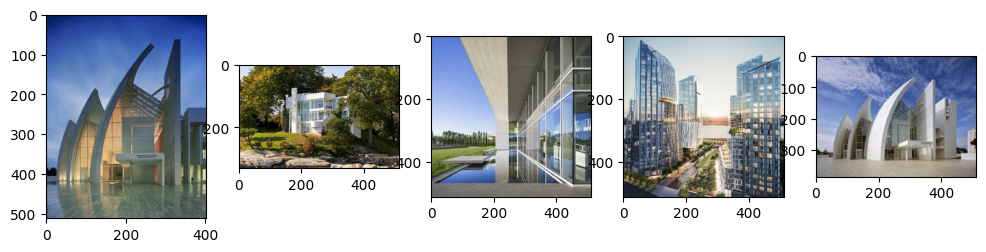

In [170]:
content_path = content[0]
style_path = style[5]
print("Example path : ", content_path)

# Visualizing original content images
content_image = load_img(content_path)
style_image = load_img(style_path)


for i in range(5):
  plt.subplot(1,5,i+1)
  imshow(load_img(content[i]))

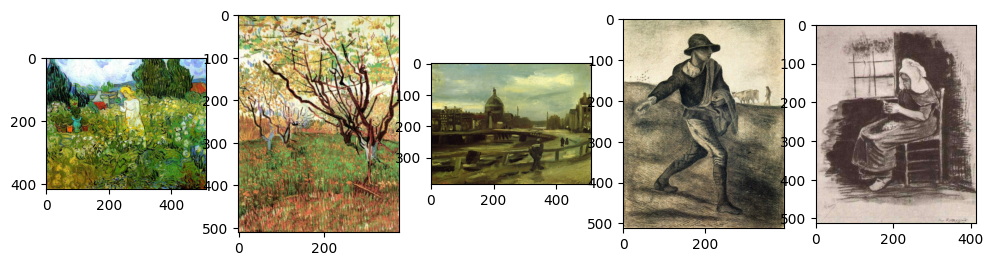

In [171]:
# Visualizing Style Images
for i in range(5):
  plt.subplot(1,5,i+1)
  imshow(load_img(style[i]))


 In python, the glob module is used to retrieve files/pathnames matching a specified pattern. The pattern rules of glob follow standard Unix path expansion rules.

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.


Following the original NST paper (https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers).


### Loading VGG Model in Keras

In [172]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
print(vgg.summary())

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

##**3 - New model**
**Why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?**

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image.
* This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances.
* Thus, between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

In [173]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')      # Include_top is False as we dont need the VGG dense layers.
for layer in vgg.layers:
  print(layer.name)

content_layers = ['block5_conv2']     # Subject to experimantation

style_layers = ['block1_conv1',       # Subject to experimantation
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

input_20
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### Defining model using the functional API

Specify the inputs and outputs:
`model = Model(inputs, outputs)`

In [174]:
### Creates a VGG model that returns a list of intermediate output values.

def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)      # Using Functional API of Keras
  return model


block1_conv1
  shape:  (1, 294, 512, 64)

block2_conv1
  shape:  (1, 147, 256, 128)

block3_conv1
  shape:  (1, 73, 128, 256)

block4_conv1
  shape:  (1, 36, 64, 512)

block5_conv1
  shape:  (1, 18, 32, 512)



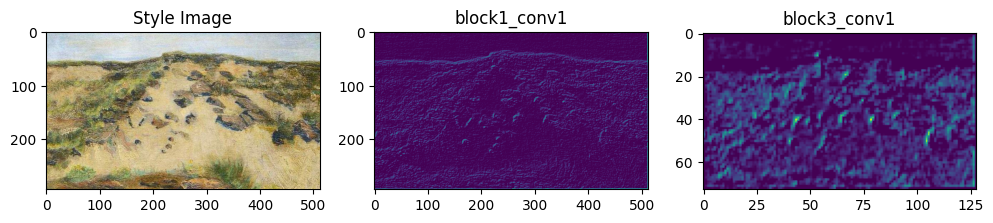

In [175]:
# To create the model:
new_model = vgg_layers(style_layers)
style_outputs = new_model(style_image*255)

#To visualize these layers
plt.subplot(1, 3, 1)
imshow(style_image, 'Style Image')
plt.subplot(1, 3, 2)
imshow(tf.convert_to_tensor(style_outputs[0])[0,:,:,0], 'block1_conv1')
plt.subplot(1, 3, 3)
imshow(tf.convert_to_tensor(style_outputs[2])[0,:,:,0], 'block3_conv1')

# Looking at each layer in the new model
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print()

## **4 - Style matrix**

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are
<font color='red'>
${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$.


*   $G_{ij}$ compares how similar $v_i$ is to $v_j$
*   If they are highly similar, we would expect them to have a large dot product, and thus for $G_{ij}$ to be large.

The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$.




\
### Gram Matrix

The gram matrix of A is $G_A = AA^T$. Gram Matrix is implemented using the [tf.linalg.einsum](https://www.tensorflow.org/api_docs/python/tf/einsum) function:

In [176]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## **5 - Style and Content Loss**
Suppose we set an image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in a random layer. This will be a $n_H \times n_W \times n_C$ tensor (Height, Width, Channels).\
Repeating this process with the image G. Seting G as input, and running forward progation. Let $$a^{(G)}$$ be the corresponding hidden layer activation.


### Style Loss
After generating the Style matrix (Gram matrix), our goal is to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$ for style, and the corresponding style cost for this layer is defined as:
<font color='red'>
$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\ $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.\
Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer chosen, and appear in a normalization term in the cost.

### Content Loss
Then we define the content cost function as:
<font color='red'>
$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\ $$

Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations.

### Total Cost
Cost function that minimizes both the style and the content cost. The formula is:
<font color='red'>
$$J(G) = content\_weight * J_{content}(C,G) + style\_weight * J_{style}(S,G)$$

In [190]:
### Function for defining Total Cost

# Note that the content loss equations mai be slightly changed from what is mentioned in the arxiv paper,
# this doesnot appreciably affect performance
tf.keras.backend.clear_session()

def style_content_loss(outputs, content_targets, style_targets, content_weight, style_weight):
    style_output = outputs['style']
    content_output = outputs['content']

    style_loss = 0.25*tf.add_n([tf.reduce_mean((style_output[name]-style_targets[name])**2)
                                                    for name in style_output.keys()])# tf.add_n returns the element-wise sum of a list of tensors.
    style_loss *= style_weight / num_style_layers

    # tf.reduce_mean reduces input_tensor along the dimensions given in axis by computing the mean of elements across the dimensions in axis



    content_loss = 0.25*tf.add_n([tf.reduce_mean((content_output[name]-content_targets[name])**2) for name in content_output.keys()])
    content_loss *= content_weight / num_content_layers


    loss = style_weight*style_loss + content_weight*content_loss    # Total Loss

    return loss

### Extract style and content

When called on an image, this model returns the gram matrix (style) of the
style_layers and content of the content_layers:

In [178]:
### Combining Style and Content for the Image in a single Dictionary

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0

    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)

    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)        #Converting style layer to Gram Matrix
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [179]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

# Setting style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

\
 As shown be the code below,
  * Gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is.
  * For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture.

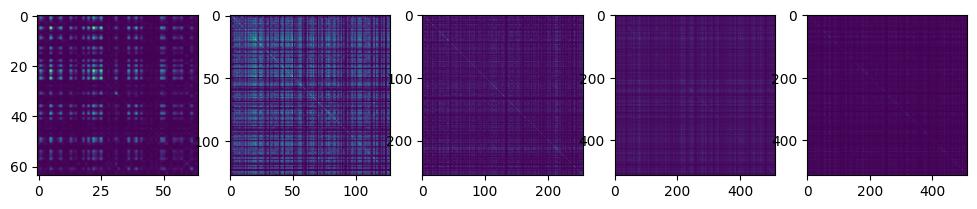

In [180]:
#For visualizing Gram Matrix diagonal elements
for i in range(len(style_layers)):
  plt.subplot(1,5,i+1)
  imshow(results['style'][style_layers[i]][0,:,:])

## **6 - Training using Gradient Descent**

In [181]:
# A function to keep the pixel values between 0 and 1:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Defining an optimizer, Adam optimizer taken here
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Style and content target values:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

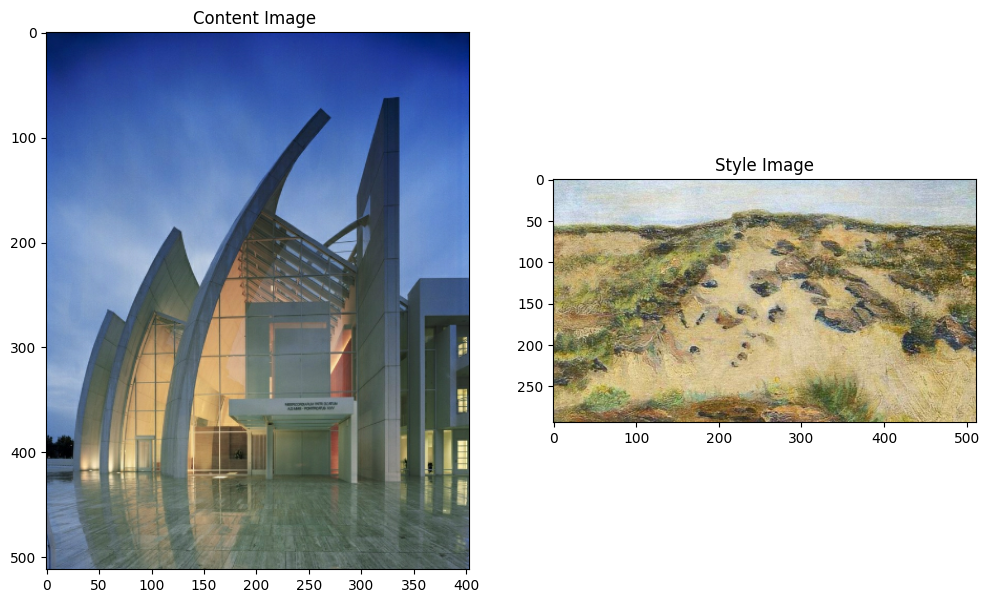

In [191]:
image = tf.Variable(content_image)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image ')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

def train_step(image, content_targets, style_targets, content_weight, style_weight):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, content_targets, style_targets, content_weight, style_weight)
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return loss

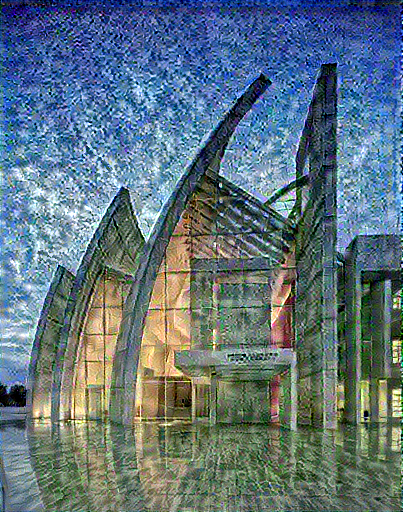

Train steps completed: 200
Loss -  29456490000.0


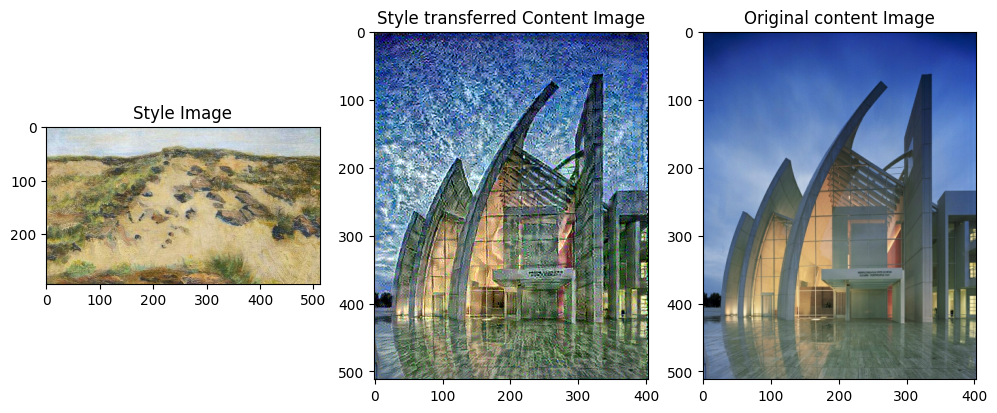

In [193]:
### Training starts here
epochs = 10
steps_per_epoch = 20         # How many steps the model trains in one epoch

style_weight=1           # weight of style image
content_weight= 1e5

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    loss = train_step(image, content_targets, style_targets, content_weight, style_weight)
    print("*", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train steps completed: {}".format(step))
  print("Loss - ", loss.numpy(), flush = False)


plt.subplot(1,3,1)
imshow(style_image, "Style Image")
plt.subplot(1,3,3)
imshow(content_image, "Original content Image")
plt.subplot(1,3,2)
imshow(image,"Style transferred Content Image")

## **7 - Evaluating Effectiveness of model**

Using Same Content image but different Style Images. Below is a function that displays a styled image with the content and style images.

Change *a(content image) & b(style image)* for changing content and styling images. Also, losses for each image after training is printed with the styled image itself.

In [227]:
def evaluate(content_file, style_file, c_weight, s_weight):
  c_path = content[content_file]
  s_path = style[style_file]

  # Code for loading content and style image
  c_image = load_img(c_path)
  image2 = tf.Variable(c_image)
  s_image = load_img(s_path)

  # Code for content_target tensor according to new style image
  results = extractor(c_image)
  # Setting style and content target values:
  s_targets = extractor(s_image)['style']
  c_targets = extractor(c_image)['content']

  epochs = 10
  steps_per_epoch = 50    # How many steps the model trains in one epoch

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      loss = train_step(image2, c_targets, s_targets, c_weight, s_weight)
      print("*", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image2))
    print("Train steps completed: {}".format(step))
    print("Loss - ", loss.numpy(), flush = False)

  plt.subplot(1,3,1)
  imshow(s_image, "Style Image")
  plt.subplot(1,3,3)
  imshow(c_image, "Original content Image")
  plt.subplot(1,3,2)
  imshow(image2,"Style transferred Content Image")

  #content_loss = 0.25*tf.add_n([tf.reduce_mean((c_image-image2)**2)])
  #style_loss = 0.25*tf.add_n([tf.reduce_mean((s_image-s_targets)**2)])
  #print("The content Loss for this Image is: ", content_loss)
  #print("The style Loss for this Image is: ", style_loss)

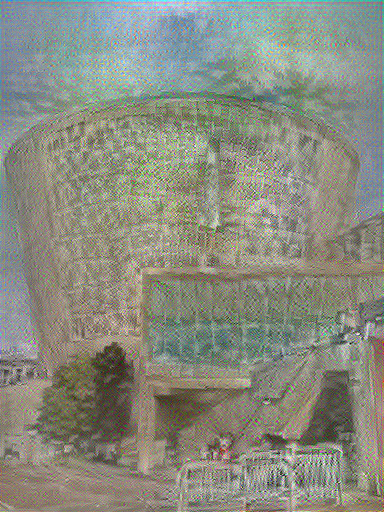

Train steps completed: 500
Loss -  659475860000.0


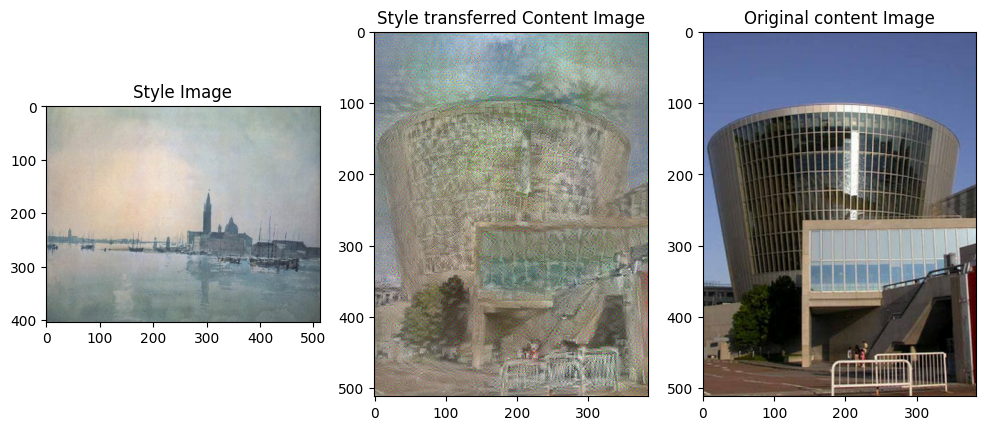

In [220]:
#Example 1
evaluate(150, -30, c_weight = 1e5, s_weight = 100)

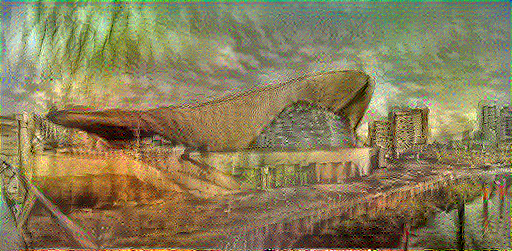

Train steps completed: 500
Loss -  72330740.0


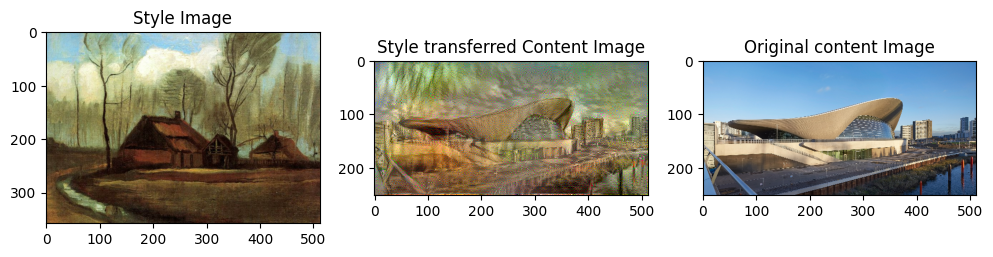

In [219]:
#example2
evaluate(-100, -500, 1000, 1)

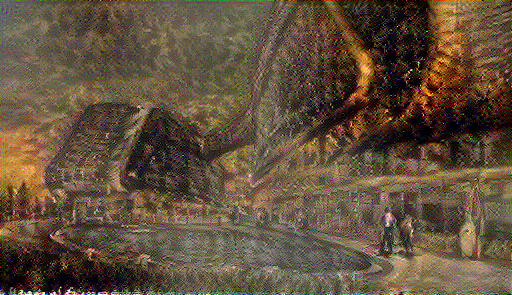

Train steps completed: 500
Loss -  130670270.0


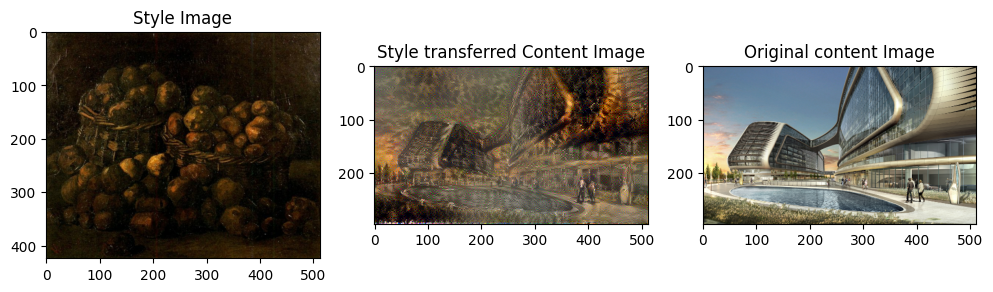

In [222]:
#example3
evaluate(-200, -300, 1e3, 1)

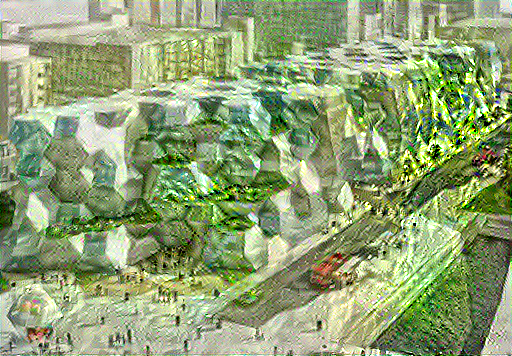

Train steps completed: 500
Loss -  1441600300.0


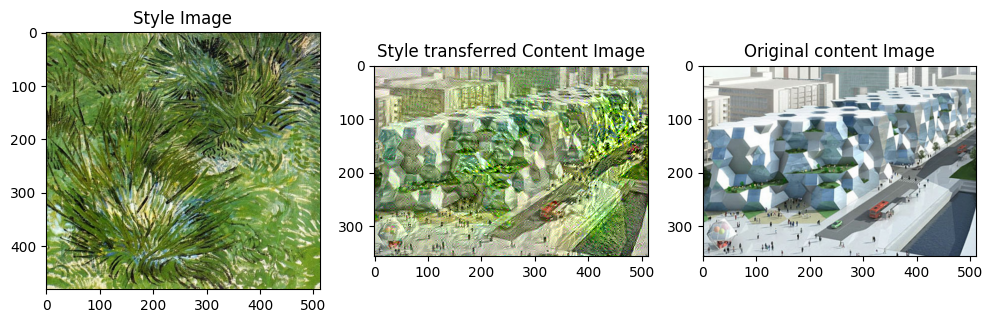

In [230]:
#example4
evaluate(-300, -400, 1e4, 1)

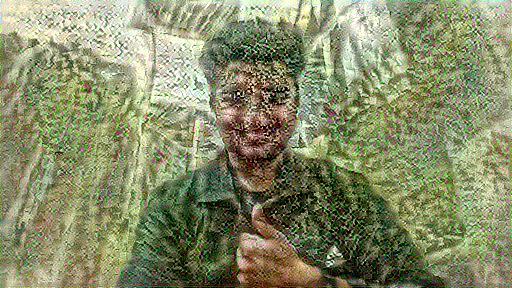

Train steps completed: 200
Loss -  13741380.0


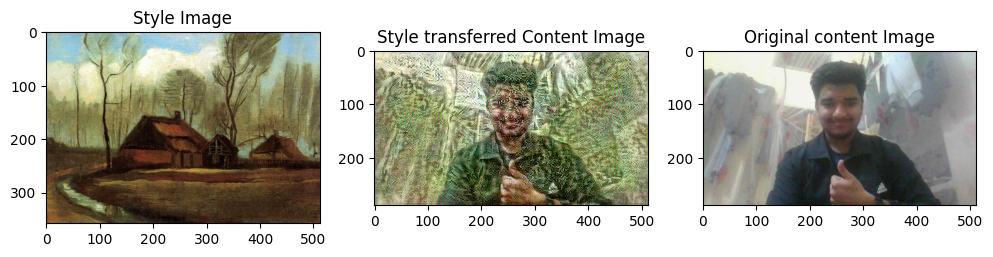

In [249]:
def evaluate(style_file, c_weight, s_weight):
  c_path = "aryan.jpg"
  s_path = style[style_file]

  # Code for loading content and style image
  c_image = load_img(c_path)
  image2 = tf.Variable(c_image)
  s_image = load_img(s_path)

  # Code for content_target tensor according to new style image
  results = extractor(c_image)
  # Setting style and content target values:
  s_targets = extractor(s_image)['style']
  c_targets = extractor(c_image)['content']

  epochs = 10
  steps_per_epoch = 20    # How many steps the model trains in one epoch

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      loss = train_step(image2, c_targets, s_targets, c_weight, s_weight)
      print("*", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image2))
    print("Train steps completed: {}".format(step))
    print("Loss - ", loss.numpy(), flush = False)

  plt.subplot(1,3,1)
  imshow(s_image, "Style Image")
  plt.subplot(1,3,3)
  imshow(c_image, "Original content Image")
  plt.subplot(1,3,2)
  imshow(image2,"Style transferred Content Image")

#example5
evaluate(-500, 1e3, 0.1)

## **8 - Conclusion**
We are now able to use Neural Style Transfer to generate artistic images.


- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet.
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images.

# **Limitations of my Model**
Below I have listed the limitations of Neural Style Transfer (NST) Model that I have made.
* *COMPUTATIONALLY EXPENSIVE* : For high resolution images, computing and optimizing for nerual style transfer is very computationally heavy and without GPU backed training, it is very time consuming.
* *LOGICAL INCOHERENCE*: Sometimes, the images outputted by the NST may not make sense. For example- model might transfer style of photo of a cat to a photo of a dog, which may result in the dog looking like a cat.
* *STYLE CONTROL*: It is hard to control where the style is being applied on the content image, since this depends on which layer of CNN is being used.
* *RESOLUTION LIMITATION*: NST struggles to produce high quality images since the layers of CNN used typically doesnot support very high resolution images. So, they may not capture all the details of the content image.

# **Potential improvements of my Model**
Below are some improvements that can still be made to my model.
* *Interpretable and controllable style transfer*: Making NST model more interpretable which will allow for better control over the style transfer process.

* *Code readability*: In this notebook, beacuse of a time crunch, the code written may not be easily readable for every reader. Code readability can be worked upon.

* *Performace*: Without a GPU session, the style transfer itself is very time consuming, thus, more-preprocessing can be done for both content and style image to make them lightweight while preserving as much of the content as possible (Using image compression for example).

* *Generative adversarial networks (GANs)*: GANs can be incorporated for making NST models, but due to computational and time limitations, this path wasn't taken.

* *Using better Loss function*: In some Images, over styling is seen, even with setting higher weights for the content image. Writing better loss function will help mitigating this.